# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156231 sha256=07b0710149d79995cafdd0085b31ed39d287ff3daf9d99a3bcd7da8fedd6f81c
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, accuracy

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
file_path = "/content/drive/MyDrive/DS+ML/R_Systems/ratings_Electronics.csv"
df = pd.read_csv(file_path)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [7]:
# Get the column containing the users
users = df.iloc[:, 0]

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.iloc[:, 0].isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.iloc[:, 1]

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.iloc[:, 1].isin(remove_users)]

In [11]:
# Print a few rows of the imported dataset
df_final.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1309,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1321,A1A5KUIIIHFF4U,1400501466,1.0,1332547200
1334,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
1450,AW3LX47IHPFRL,1400501466,5.0,1339804800
1455,A1E3OB6QMBKRYZ,1400501466,1.0,1350086400


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [12]:
# Check the number of rows and columns and provide observations
num_rows, num_columns = df_final.shape
print(f"The dataframe has {num_rows} rows and {num_columns} columns.")


The dataframe has 65290 rows and 4 columns.


**Write your observations here:**

The data now only has 65,290 rows instead of the initial 7,824,482. This means that we have substantially reduced the data, meaning we will have a much more focused analysis. The data structure still has 4 columns keeping the data simple. Now we will have be able to train the model more effecienctly and our EDA is more feasible. A downside to this reduction is that we have created potential bias as our data now only consists of users who rate more frequently and products that have more ratings.

### **Data types**

In [13]:
# Check Data types and provide observations
print(df_final.dtypes)

AKM1MP6P0OYPR     object
0132793040        object
5.0              float64
1365811200         int64
dtype: object


**Write your observations here:**

The dataset columns shows the user and product IDs as object types, this tells us that they are alphanumeric strings. The ratings are shown as type float64, whilst the timestamps are stored as Unix timestamps int64. The column names are not named and unclear, so renaming them for clarity might be beneficial.

### **Checking for missing values**

In [14]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()
print(missing_values)

AKM1MP6P0OYPR    0
0132793040       0
5.0              0
1365811200       0
dtype: int64


**Write your observations here:**

The dataset has no missing values. This means that the data collection was thorough and no imputation or cleaning methods are required to handle nulls.

### **Summary Statistics**

In [15]:
# Summary statistics of 'rating' variable and provide observations
rating_stats = df_final['5.0'].describe()
print(rating_stats)

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: 5.0, dtype: float64


**Write your observations here:**

Central tendency: Average rating is 4.29 which is pretty high on a scale that goes up to 5. Meaning the majority of the products are liked by the customers.

Dispersion: The standard deviation is 0.989, suggesting that the ratings deviate by less that a full point. Meaning they are relatively concentrated around the mean.

Range: ratings range from 1-5 meaning that some achieved the lowest score and some received highest.

Distribution: 50% of the ratings are 5, meaning half the dataset have products with perfect ratings. 75% of the dataset scored 5 or below, once again telling us the scores are quite high for the products. 25% are 4 or below, telling us that most the customers are satisfied with the products.

### **Checking the rating distribution**

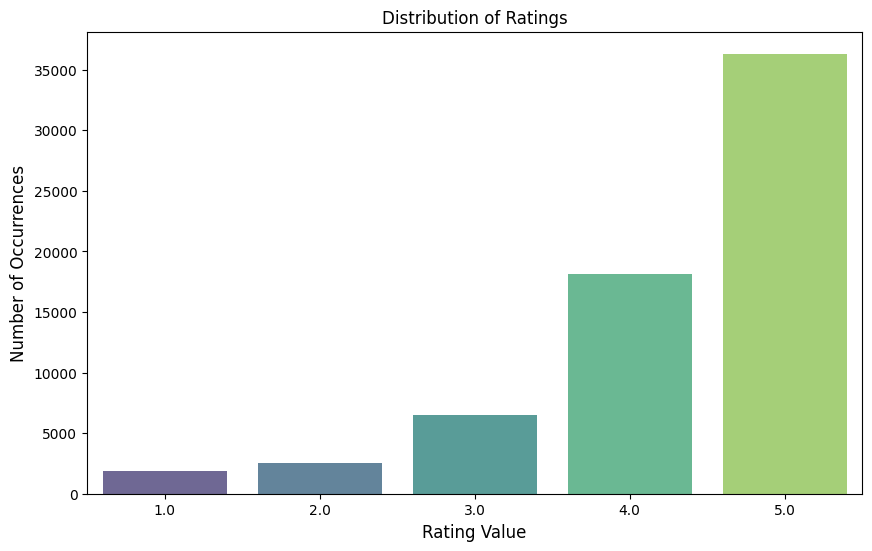

In [16]:
# Create the bar plot and provide observations

# Get the distribution of ratings
rating_distribution = df_final['5.0'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_distribution.index, y=rating_distribution.values, alpha=0.8, palette="viridis")
plt.title('Distribution of Ratings')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Rating Value', fontsize=12)
plt.show()

**Write your observations here:**

Most frequent rating is the score of 5. The least frequent is 1. Indicating that most of the ratings are really high. The ratings also trend upwards, meaning that users tend to give higher ratings

### **Checking the number of unique users and items in the dataset**

In [17]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of unique users
unique_users = df_final.iloc[:, 0].nunique()

# Number of unique products
unique_products = df_final.iloc[:, 1].nunique()

# Total rows in the dataset
total_rows = df_final.shape[0]

print(f"Total rows in the dataset: {total_rows}")
print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")


Total rows in the dataset: 65290
Number of unique users: 1540
Number of unique products: 5689


**Write your observations here:**

On average, each user has given a rating to 65290/1540 = 42 products. This means that our filtering worked as we selected users who rated atleast 50 products.

On average, each product has received a rating from 65290/5689 = 11.5 users. This tells us that there must be some popular products which received a lot of ratings and other products which received none.



### **Users with the most number of ratings**

In [18]:
# Top 10 users based on the number of ratings
top_users = df_final.iloc[:, 0].value_counts().head(10)

print(top_users)

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: AKM1MP6P0OYPR, dtype: int64


**Write your observations here:**

The top user is really active given he submitted nearly 300 ratings. The distrubution amongst these users is relatively high with the lowest amount of ratings being 179 and the highest 295. These users can hugely influence the reccomendation system as they provide a broader range of feedback for many products.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [19]:
# Calculate the average rating for each product
average_ratings = df_final.groupby(df_final.columns[1])['5.0'].mean()

# Calculate the count of ratings for each product
count_ratings = df_final.groupby(df_final.columns[1])['5.0'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'Average_Rating': average_ratings,
    'Rating_Count': count_ratings
})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating.head())

            Average_Rating  Rating_Count
0132793040                              
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8


In [20]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(dataframe, min_interactions=5, n=50):
    """
    Parameters:
    - dataframe
    - min_interactions: Minimum number of ratings for the product to be considered.
    - n: Number of top products to return.

    Returns:
    - top_n: Dataframe of top n products.
    """

    # Finding products with minimum number of interactions
    filtered_products = dataframe[dataframe['Rating_Count'] >= min_interactions]

    # Sorting values with respect to average rating
    sorted_products = filtered_products.sort_values(by='Average_Rating', ascending=False)

    # Get the top n products
    top_n = sorted_products.head(n)

    return top_n



### **Recommending top 5 products with 50 minimum interactions based on popularity**




In [21]:
top_5_products = top_n_products(final_rating, min_interactions=50, n=5)
print(top_5_products)

            Average_Rating  Rating_Count
0132793040                              
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [22]:
top_5_products_100_interactions = top_n_products(final_rating, min_interactions=100, n=5)
print(top_5_products_100_interactions)

            Average_Rating  Rating_Count
0132793040                              
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [23]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [24]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [25]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['AKM1MP6P0OYPR', '0132793040', '5.0']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [26]:
from collections import defaultdict
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # cosine similarity
    'user_based': True  # user-user similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model = KNNBasic(sim_options=sim_options, verbose=False)

# Fit the model on the training data
model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model)

RMSE: 1.0119
Precision:  0.849
Recall:  0.861
F_1 score:  0.855


**Write your observations here:**

RMSE of 1.0217 shows that the model's predictions are on average 1 rating away from the actual rating, in this context the margin of error is relatively high.

Precision of 0.853 means that 85% of the time the model reccomends something relevant to the user. Meaning it is quite effective in that sense but there is room for improvement.

F_1 score of 0.859 shows a balanced performance between precision and recall.



Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [27]:
# Predicting rating for a sample user with an interacted product

# User and product IDs
user_id = "A3LDPF5FMB782Z"
product_id = "1400501466"

# Making the prediction
prediction = model.predict(user_id, product_id, verbose=True)

# Extracting the estimated rating from the prediction object
estimated_rating = prediction.est

print(f"Estimated Rating for User '{user_id}' and Product '{product_id}': {estimated_rating}")


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
Estimated Rating for User 'A3LDPF5FMB782Z' and Product '1400501466': 4.294302343391025


**Write your observations here:**

The system predicts a high rating of 4.30 for the user A3LDPF5FMB782Z with the item 1400501466.
The prediction was made despite facing challenges due to data sparsity, as indicated by the was_impossible flag being True and the reason 'Not enough neighbors.'.
This lack of sufficient similar users suggests a potential area of improvement for the model.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [28]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_users = df_final[df_final['0132793040'] != "1400501466"]['AKM1MP6P0OYPR'].unique()
print(unique_users)

['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [29]:
# Predicting rating for a sample user with a non interacted product
uid = 'A3LDPF5FMB782Z'  # user ID
iid = 'XYZ123'  # item ID (product ID)

pred = model.predict(uid, iid, verbose=True)


user: A3LDPF5FMB782Z item: XYZ123     r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


**Write your observations here:**

The recommendation system predicts a rating of 4.3 for user A3LDPF5FMB782Z on the product XYZ123, which the user hasn't previously interacted with. However, this prediction is less reliable because the model flagged it as "impossible" due to the unfamiliarity with either the user, the item, or both. This highlights the cold start problem, where the system struggles to predict for new users or items. In such cases, other recommendation strategies might be more suitable.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [32]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 40, 60, 80, 100],   # max neighbors
    'min_k': [1, 5, 10],   # min neighbors
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
        'user_based': [True, False]  # compute  similarities between users
    }
}
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['AKM1MP6P0OYPR', '0132793040', '5.0']], reader)
trainset = data.build_full_trainset()
gs.fit(data)

# Best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best parameters combination:", gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [33]:
# Using the optimal similarity measure for user-user based collaborative filtering
best_params = gs.best_params['rmse']
k = best_params['k']
sim_options = best_params['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
algo = KNNBasic(k=k, sim_options=sim_options)

# Training the algorithm on the trainset
trainset = data.build_full_trainset()
algo.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(algo, k=10)



Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8492
Precision:  0.864
Recall:  0.888
F_1 score:  0.876


**Write your observations here:**

RMSE of 0.8492 means that the model's predicted rating for certain products deviate by 0.85 points to the actual user given ratings. This model's RMSE is better than the others but still it is relatively quite high given that the ratings are given on a scale from 1-5

Precision of 0.864 means that if amazon were to suggest the top 10 products to a user, then 86.4% of them the user would indeed like or purchase. Which in this instance is really good.

Recall of 0.888 means that out of all the products the user might like, amazon would successfully reccommend 88.8% of them in the top 10 products.

F_1 score of 0.86 is quite high meaning that the model is both precise and sensitive.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [36]:
from surprise import KNNBasic, Dataset, Reader

# Define the optimal parameters
sim_options = {
    'name': 'cosine',  # use cosine similarity measure (as an example)
    'user_based': True  # user-based collaborative filtering
}

# Create a KNNBasic instance with the optimal parameters
optimized_algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on your dataset
trainset = data.build_full_trainset()
optimized_algo.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [38]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
pred_optimized_A3LDPF5FMB782Z = optimized_algo.predict("A3LDPF5FMB782Z", "1400501466")
print(f"Predicted rating for user A3LDPF5FMB782Z for product 1400501466 using the optimized model: {pred_optimized_A3LDPF5FMB782Z.est}")

Predicted rating for user A3LDPF5FMB782Z for product 1400501466 using the optimized model: 3.3333333333333335


In [39]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred_optimized_A34BZM6S9L7QI4 = optimized_algo.predict("A34BZM6S9L7QI4", "1400501466")
print(f"Predicted rating for user A34BZM6S9L7QI4 for product 1400501466 using the optimized model: {pred_optimized_A34BZM6S9L7QI4.est}")

Predicted rating for user A34BZM6S9L7QI4 for product 1400501466 using the optimized model: 1.9931452874171676


In [58]:
from surprise import BaselineOnly

# Train the BaselineOnly algorithm
bsl_options = {'method': 'sgd', 'n_epochs': 20}  # using Stochastic Gradient Descent
algo1 = BaselineOnly(bsl_options=bsl_options)
algo1.fit(trainset)

# Convert raw ids to inner ids
inner_uid = trainset.to_inner_uid("A3LDPF5FMB782Z")
inner_iid = trainset.to_inner_iid("1400501466")

# Compute baseline estimate for the user and the item
baseline_estimate_A3LDPF5FMB782Z = trainset.global_mean + algo1.bu[inner_uid] + algo1.bi[inner_iid]

print(f"Baseline estimate for user A3LDPF5FMB782Z for product 1400501466: {baseline_estimate_A3LDPF5FMB782Z}")

# Do the same for the other user
inner_uid = trainset.to_inner_uid("A34BZM6S9L7QI4")
baseline_estimate_A34BZM6S9L7QI4 = trainset.global_mean + algo1.bu[inner_uid] + algo1.bi[inner_iid]

print(f"Baseline estimate for user A34BZM6S9L7QI4 for product 1400501466: {baseline_estimate_A34BZM6S9L7QI4}")


Estimating biases using sgd...
Baseline estimate for user A3LDPF5FMB782Z for product 1400501466: 3.8852456053763422
Baseline estimate for user A34BZM6S9L7QI4 for product 1400501466: 4.191848101756269


**Write your observations here:**

This shows us that the optimized model with the first user was much more accurate as it was only off by 0.5 points. Where as for the second user it was over 2 points therefore inneffective.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [44]:
# 0 is the inner id of the above user
sim_options = {
    'name': 'msd',  # specify the distance metric to be msd
    'user_based': True
}

algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Get the 5 most similar users to the user with internal id 0
inner_uid = 0
neighbors = algo.get_neighbors(inner_uid, k=5)

# Convert internal ids of the neighbors back to raw ids
raw_uids = [trainset.to_raw_uid(inner_id) for inner_id in neighbors]
inner_uid = 0
neighbors = algo.get_neighbors(inner_uid, k=5)

# Convert internal ids of the neighbors back to raw ids
raw_uids = [trainset.to_raw_uid(inner_id) for inner_id in neighbors]

print(f"5 most similar users to user with internal id 0 are: {raw_uids}")

Computing the msd similarity matrix...
Done computing similarity matrix.
5 most similar users to user with internal id 0 are: ['AW3LX47IHPFRL', 'A19N3S7CBSU6O7', 'A1VHCO8RQFIGQJ', 'A1OGCPMSIVK7G4', 'ABVYGB2TKBO8F']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [45]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [49]:
df_final.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommended_products = get_recommendations(data=df_final, user_id='A3LDPF5FMB782Z', top_n=5, algo=optimized_algo)

# Outputting the recommendations
print(f"Top 5 recommended products for user A3LDPF5FMB782Z are: {recommended_products}")


Top 5 recommended products for user A3LDPF5FMB782Z are: [('1400599997', 5), ('B00000DM9W', 5), ('B00000K4KH', 5), ('B00001P4XH', 5), ('B00001W0DI', 5)]


In [50]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, optimized_algo)
df_recommendations = pd.DataFrame(recommendations, columns=["prod_id", "predicted_ratings"])
print(df_recommendations)

      prod_id  predicted_ratings
0  1400599997                  5
1  B00000DM9W                  5
2  B00000K4KH                  5
3  B00001P4XH                  5
4  B00001W0DI                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [51]:
from surprise import KNNBasic, accuracy
from surprise.model_selection import train_test_split

# 1. Define the similarity options for item-item collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# 2. Use KNNBasic algorithm with the defined similarity options
algo = KNNBasic(sim_options=sim_options)

trainset, testset = train_test_split(data, test_size=0.25, random_state=1)

# Train the algorithm on the trainset
algo.fit(trainset)

# 3. Predict ratings for the test set
predictions = algo.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)

# 4. Compute precision@k, recall@k, and f_1 score with k = 10
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)
precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)
f1_score_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

print(f'Precision@10: {precision_at_k:.4f}')
print(f'Recall@10: {recall_at_k:.4f}')
print(f'F1 Score@10: {f1_score_at_k:.4f}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0287
Precision@10: 0.8284
Recall@10: 0.8137
F1 Score@10: 0.8210


**Write your observations here:**

RMSE of 1.0287 is really high which indicates big difference between ratings

Precision of 82.84% means that around 82.84% of the top 10 recommended items are relevant which is high and good.

Recall of 81.37% shows the top 10 recommended items capture 81% of the relevant products to the user.

The F_1 score of 0.821 tells us that the model maintains a good balance between precision and recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [59]:
# Predicting rating for a sample user with an interacted product
predicted_rating = algo.predict("A3LDPF5FMB782Z", "1400501466")
print(f"Predicted rating for user A3LDPF5FMB782Z for product 1400501466: {predicted_rating.est}")

inner_uid = trainset.to_inner_uid("A3LDPF5FMB782Z")
inner_iid = trainset.to_inner_iid("1400501466")

user_bias = algo1.bu[inner_uid]
item_bias = algo1.bi[inner_iid]

baseline_estimate = trainset.global_mean + user_bias + item_bias
print(f"Baseline estimate for user A3LDPF5FMB782Z for product 1400501466: {baseline_estimate}")


Predicted rating for user A3LDPF5FMB782Z for product 1400501466: 4.2631578947368425
Baseline estimate for user A3LDPF5FMB782Z for product 1400501466: 3.8852456053763422


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [60]:
# Predicting rating for a sample user with a non interacted product
# Predicting rating for a sample user with an interacted product
predicted_rating = algo.predict("A34BZM6S9L7QI4", "1400501466")
print(f"Predicted rating for user A34BZM6S9L7QI4 for product 1400501466: {predicted_rating.est}")

inner_uid = trainset.to_inner_uid("A34BZM6S9L7QI4")
inner_iid = trainset.to_inner_iid("1400501466")

user_bias = algo1.bu[inner_uid]
item_bias = algo1.bi[inner_iid]

baseline_estimate = trainset.global_mean + user_bias + item_bias
print(f"Baseline estimate for user A34BZM6S9L7QI4 for product 1400501466: {baseline_estimate}")


Predicted rating for user A34BZM6S9L7QI4 for product 1400501466: 4.0
Baseline estimate for user A34BZM6S9L7QI4 for product 1400501466: 4.191848101756269


### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [61]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
grid_search.fit(data)

# Find the best RMSE score
print("Best RMSE score:", grid_search.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print("Best parameters:", grid_search.best_params['rmse'])



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [65]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, [])
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Call the above function
precisions, recalls = precision_recall_at_k(predictions_optimized, k=10, threshold=3.5)

# Calculating average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Calculating f1_score
avg_f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

print(f"Precision@10: {avg_precision}")
print(f"Recall@10: {avg_recall}")
print(f"F1 Score@10: {avg_f1_score}")


Precision@10: 0.8297340849920208
Recall@10: 0.9039846107910203
F1 Score@10: 0.8652693723681448


In [67]:
# Training the algorithm on the trainset
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)
# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_algo = KNNBasic(k=20, min_k=6, sim_options={'name': 'msd', 'user_based': False})
optimized_algo.fit(trainset)

# Predicting ratings for the testset
predictions_optimized = optimized_algo.test(testset)

# Calculating RMSE
rmse_optimized = accuracy.rmse(predictions_optimized)

# For precision@k and recall@k, use the precision_recall_at_k function
precisions, recalls = precision_recall_at_k(predictions_optimized, k=10, threshold=3.5)

# Calculating average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

# Calculating f1_score
avg_f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

print(f"Optimized RMSE: {rmse_optimized}")
print(f"Precision@10: {avg_precision}")
print(f"Recall@10: {avg_recall}")
print(f"F1 Score@10: {avg_f1_score}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9752
Optimized RMSE: 0.9751572811411542
Precision@10: 0.8297340849920208
Recall@10: 0.9039846107910203
F1 Score@10: 0.8652693723681448
